In [1]:
import tensorflow as tf
import numpy as np
import re
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.datasets import mnist
from matplotlib import pyplot as plt
from google.colab import files

Using TensorFlow backend.


In [0]:
#@title Layers
SEED = 123456
rng = np.random.RandomState(SEED)


def __createWeights(shape, seed=None, name='weight'):
    w_init = tf.contrib.layers.variance_scaling_initializer(seed=seed)
    return tf.get_variable(name + '_w', shape=shape, initializer=w_init)


def __createBiases(size, name='bias'):
    return tf.get_variable(name + '_b', shape=[size], initializer=tf.constant_initializer(0.0))


def LeakyReLU(x, alpha=0.1):
    x = tf.nn.leaky_relu(x, alpha=alpha)
    return x


def MaxPooling(x, ksize=2, stride_length=2, padding='SAME', data_format='NHWC'):
    x = tf.nn.max_pool(x, (1, ksize, ksize, 1), (1, stride_length, stride_length, 1), padding, data_format)
    return x


def GlobalAveragePooling(x):
    x = tf.reduce_mean(x, [1, 2])
    return x


def Dense(x, input_dim, output_dim, seed=None, name='dense'):
    W = __createWeights([input_dim, output_dim], seed, name) 
    b = __createBiases(output_dim, name) 
    x = tf.nn.xw_plus_b(x, W, b)
    return x


def Conv2D(x, filter_size, n_channels, n_filters, stride_length=1, padding='SAME', data_format='NHWC', name='conv'):
    shape = [filter_size, filter_size, n_channels, n_filters]
    W = __createWeights(shape, name=name)
    b = __createBiases(n_filters, name=name)
    x = tf.nn.conv2d(x, filter=W, strides=(1, stride_length, stride_length, 1), padding=padding, data_format=data_format)
    x += b
    return x


def Dropout(x, probability=0.5):
    x = tf.nn.dropout(x, keep_prob=probability, seed=rng.randint(SEED))
    return x


def GaussianNoise(x, sigma=0.15):
    noise = tf.random_normal(shape=tf.shape(x), stddev=sigma)
    x += noise
    return x


def SoftMax(x):
    x = tf.nn.softmax(x)
    return x



'''
Loss functions. Arg 1: Approximation, Arg 2: Labels
'''
def CrossEntropyWithLogits(logits, labels):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
    return loss


# Formula: sum(p_i * log(p_i) - p_i * log(q_i))
def KLDivergenceWithLogits(q, p):
    p_soft = SoftMax(p)
    # plogp = tf.reduce_mean(tf.reduce_sum(p_soft * tf.nn.log_softmax(p), 1))
    # plogq = tf.reduce_mean(tf.reduce_sum(p_soft * tf.nn.log_softmax(q), 1))
    distance = tf.reduce_sum(p_soft * tf.nn.log_softmax(p) - p_soft * tf.nn.log_softmax(q))
    # distance = plogp - plogq
    return distance


In [0]:

'''
The model before AdD is applied
'''
def upperBlock(x, conv_size=[128, 256, 512, 256,128]):
    x =  GaussianNoise(x)
    x =  Conv2D(x, filter_size=3, n_channels=1, n_filters=conv_size[0], padding='SAME', name='1a')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=3, n_channels=conv_size[0], n_filters=conv_size[0], name='1b')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=3, n_channels=conv_size[0], n_filters=conv_size[0], name='1c')
    x =  MaxPooling(x, ksize=2, stride_length=2)
    x =  Dropout(x, probability=0.5)
    
    x =  Conv2D(x, filter_size=3, n_channels=conv_size[0], n_filters=conv_size[1], name='2a')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=3, n_channels=conv_size[1], n_filters=conv_size[1], name='2b')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=3, n_channels=conv_size[1], n_filters=conv_size[1], name='2c')
    x =  LeakyReLU(x)
    x =  MaxPooling(x, ksize=2, stride_length=2)

    x =  Conv2D(x, filter_size=3, n_channels=conv_size[1], n_filters=conv_size[2], padding='VALID', name='3a')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=1, n_channels=conv_size[2], n_filters=conv_size[3], name='3b')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=1, n_channels=conv_size[3], n_filters=conv_size[4], name='3c')
    x =  LeakyReLU(x)
    x =  GlobalAveragePooling(x) 
    
    # x =  Dropout(x, probability=0.5)
    # x =  Dense(x, conv_size[4], 10)
    # x =  SoftMax(x)

    return x
  
def upperBlock_std(x, conv_size=[128, 256, 512, 256,128]):
    x =  GaussianNoise(x)
    x =  Conv2D(x, filter_size=3, n_channels=1, n_filters=conv_size[0], padding='SAME', name='1a_std')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=3, n_channels=conv_size[0], n_filters=conv_size[0], name='1b_std')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=3, n_channels=conv_size[0], n_filters=conv_size[0], name='1c_std')
    x =  MaxPooling(x, ksize=2, stride_length=2)
    x =  Dropout(x, probability=0.5)
    
    x =  Conv2D(x, filter_size=3, n_channels=conv_size[0], n_filters=conv_size[1], name='2a_std')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=3, n_channels=conv_size[1], n_filters=conv_size[1], name='2b_std')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=3, n_channels=conv_size[1], n_filters=conv_size[1], name='2c_std')
    x =  LeakyReLU(x)
    x =  MaxPooling(x, ksize=2, stride_length=2)

    x =  Conv2D(x, filter_size=3, n_channels=conv_size[1], n_filters=conv_size[2], padding='VALID', name='3a_std')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=1, n_channels=conv_size[2], n_filters=conv_size[3], name='3b_std')
    x =  LeakyReLU(x)
    x =  Conv2D(x, filter_size=1, n_channels=conv_size[3], n_filters=conv_size[4], name='3c_std')
    x =  LeakyReLU(x)
    x =  GlobalAveragePooling(x) 
    
    # x =  Dropout(x, probability=0.5)
    # x =  Dense(x, conv_size[4], 10)
    # x =  SoftMax(x)

    return x


'''
The model after AdD is applied
'''
def lowerBlock(x, n_in=128, n_out=10, name='fc'):
    x =  Dense(x, n_in, n_out, name=name)
    return x;

def lowerBlock_std(x, n_in=128, n_out=10, name='fc_std'):
    x =  Dense(x, n_in, n_out, name=name)
    return x;


'''
Apply adv dropout
'''
def advDropout(x, mask, Jacobian, sigma=0.05, dim=128):
    # y: output 
    # mask: current sampled dropout mask 
    # sigma: hyper-parameter for boundary 
    # Jabocian: Jacobian vector (gradient of divergence (or loss function))
    # dim: layer dimension 

    Jacobian = tf.reshape(Jacobian, [-1, dim])

    # mask = 0 --> -1 
    mask = 2 * mask - tf.ones_like(mask)

    adv_mask = mask 

    # extract the voxels for which the update conditions hold 
    # mask = 0 and J > 0 
    # or
    # mask = 1 and J < 1 
    abs_jac = tf.abs(Jacobian)
    temp = tf.cast(tf.greater(abs_jac, 0), tf.float32)
    temp = 2 * temp - 1 
    # interested in the cases when temp * mask = -1
    ext = tf.cast(tf.less(mask, temp), tf.float32)

    # keep the voxels that you want to update 
    candidates = abs_jac * ext 
    thres = tf.nn.top_k(candidates, int(dim * sigma * sigma)  + 1)[0][:,-1]

    targets = tf.cast(tf.greater(candidates, tf.expand_dims(thres, -1)), tf.float32)

    # get new mask 
    adv_mask = (mask - targets * 2 * mask + tf.ones_like(mask)) / 2.0

    output = adv_mask * x

    return output, adv_mask

In [0]:
#@title Default title text
'''
Returns a model without adversarial dropout
'''
def modelWithRandD_std(x):
    x = upperBlock_std(x)
    x = lowerBlock_std(x)
    return x

  
def modelWithRandD(x):
    x = upperBlock(x)
    x = lowerBlock(x)
    return x


'''
Returns a model with adversarial dropout
'''
def modelWithAdD(x, y, fn_loss=KLDivergenceWithLogits):
    x = upperBlock(x)
    y_no_adD = lowerBlock(x)
    loss_no_adD = fn_loss(y_no_adD, y)

    # Derivative of loss fn wrt x
    DLoss = tf.gradients(loss_no_adD, [x])
    DLoss = tf.squeeze(tf.stop_gradient(DLoss)) # Stops backpropagation

    Jacobian_approx = DLoss * x
    mask = tf.ones_like(x)

    x, _ = advDropout(x, mask, Jacobian_approx)
    x = lowerBlock(x)

    return x



def CreateBaseModel(x, y, learning_rate=0.001, optimizer=tf.train.AdamOptimizer, momentum=0.999):
    logit_rand = modelWithRandD_std(x)
    loss = CrossEntropyWithLogits(logit_rand, y)

    opt = optimizer(learning_rate=learning_rate, beta1=momentum)
    gradients = opt.compute_gradients(loss, tf.trainable_variables())
    train_op = opt.apply_gradients(gradients)

    return train_op, loss, logit_rand


'''
Create the AdD model for training
'''
def CreateAdDModel(x, y, learning_rate=0.001, optimizer=tf.train.AdamOptimizer, momentum=0.999, lmb=0.01):
    logit_rand = modelWithRandD(x)
    logit_rand_loss = CrossEntropyWithLogits(logit_rand, y)

    with tf.variable_scope(tf.get_variable_scope(), reuse=True) as scope:
        # With adversarial dropout
        logit_adD = modelWithAdD(x, y)
        logit_adD_loss = CrossEntropyWithLogits(logit_adD, y)

        # Total loss
        loss = logit_rand_loss + lmb * logit_adD_loss


    opt = optimizer(learning_rate=learning_rate, beta1=momentum)
    gradients = opt.compute_gradients(loss, tf.trainable_variables())
    train_op = opt.apply_gradients(gradients)        

    return train_op, loss, logit_rand


def createTestModel(x, y):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True) as scope:
        logit_rand = modelWithRandD(x)
        logit_rand_loss = CrossEntropyWithLogits(logit_rand, y)

        return logit_rand, logit_rand_loss


def Accuracy(logits, labels):
    y_pred = tf.argmax(logits, 1)
    y_true = tf.argmax(labels, 1)
    equality = tf.equal(y_pred, y_true)
    accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
    return accuracy


def visualize(acc, loss, param):
    x = np.arange(0, len(acc))
    name = "Baseline" if param['BASELINE'] else "Adversarial"
    plt.title("Acc trend: " + name)
    plt.plot(x, acc)
    filename = str("Accuracy_" + re.sub("{|}|:|'|,| ", "", str(param)) + ".png")
    print(filename)
    plt.savefig(filename)
#     files.download(filename)
    
    plt.close()

    plt.title("Loss trend: " + name)
    plt.plot(x, loss)
    filename = str("Loss_" + re.sub("{|}|:|'|,| ", "", str(param)) + ".png")
    print(filename)
    plt.savefig(filename)
#     files.download(filename)
    
    plt.close()
    
def visualize_both(acc, loss, acc_base, loss_base, param):
    x = np.arange(0, len(acc))
    name = param['TYPE']
    plt.title("Acc trend: " + name)
    plt.plot(x, acc, 'r')
    plt.plot(x, acc_base, 'b')
    filename = str("Accuracy_" + re.sub("{|}|:|'|,| ", "", str(param)) + ".png")
    print(filename)
    plt.savefig(filename)
#     files.download(filename)
    
    plt.close()

    plt.title("Loss trend: " + name)
    plt.plot(x, loss, 'r')
    plt.plot(x, loss_base, 'b')
    filename = str("Loss_" + re.sub("{|}|:|'|,| ", "", str(param)) + ".png")
    print(filename)
    plt.savefig(filename)
#     files.download(filename)
    
    plt.close()



def doTraining(x_train, y_train, x_test, y_test, param):
    # Training setup

    batch_size = param['BATCH_SIZE']
    epochs = param['EPOCHS']

    STEPS = len(x_train) // batch_size if param['STEPS'] is None else param['STEPS']
    TEST_STEPS = len(x_test) // batch_size if param['STEPS'] is None else param['STEPS']

    # Graph
    x_train_ph = tf.placeholder(tf.float32)
    x_test_ph = tf.placeholder(tf.float32)
    y_train_ph = tf.placeholder(tf.float32)
    y_test_ph = tf.placeholder(tf.float32)

    train_op, loss, logit_rand = CreateAdDModel(x_train_ph, y_train_ph)
    train_op_base, loss_base, logit_rand_base = CreateBaseModel(x_train_ph, y_train_ph) 
    logit_test, test_loss = createTestModel(x_test_ph, y_test_ph)
    logit_test_base, test_loss_base = createTestModel(x_test_ph, y_test_ph)


    # Accuracy Train
    accuracy_train = Accuracy(logit_rand, y_train_ph)
    accuracy_train_base = Accuracy(logit_rand_base, y_train_ph)
    

    # Accuracy Test
    accuracy_test = Accuracy(logit_test, y_test_ph)
    accuracy_test_base = Accuracy(logit_test_base, y_test_ph)
    

    acc_train_trend = []
    loss_train_trend = []
    acc_test_trend = []
    loss_test_trend = []

    
    acc_train_trend_base = []
    loss_train_trend_base = []
    acc_test_trend_base = []
    loss_test_trend_base = []

    
    
    # Training
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            # Train model
            acc_train, loss_train = 0, 0
            for i in range(STEPS):
                _, loss_, acc = sess.run([train_op, loss, accuracy_train],
                                        feed_dict={x_train_ph: x_train[batch_size * i: batch_size * (i + 1)],
                                                   y_train_ph: y_train[batch_size * i: batch_size * (i + 1)]})
                acc_train += acc
                loss_train += loss_
                
            acc_train_trend.append(acc_train)
            loss_train_trend.append(loss_train)

            # Test model
            acc_test, loss_test = 0, 0
            for i in range(TEST_STEPS):
                acc_t, loss_t = sess.run([accuracy_test, test_loss],
                                         feed_dict={x_test_ph: x_test[batch_size * i: batch_size * (i + 1)],
                                                    y_test_ph: y_test[batch_size * i: batch_size * (i + 1)]})
                
                acc_test += acc_t
                loss_test += loss_t

            acc_test_trend.append(acc_test)
            loss_test_trend.append(loss_test)
            
            print('ADV : Epoch: {} || Train Loss: {},\t Train Acc: {} || Test Loss: {},\t Test Accuracy: {}'.format(epoch,
                                                                                                          round(loss_train, 10) / STEPS,
                                                                                                          round(acc_train, 10) / STEPS,
                                                                                                          round(loss_test, 10) / TEST_STEPS,
                                                                                                          round(acc_test, 10) / TEST_STEPS))
        for epoch in range(epochs):
            # Train model
            acc_train_base, loss_train_base = 0, 0
            for i in range(STEPS):
                
                _, loss_b, acc_b = sess.run([train_op_base, loss_base, accuracy_train_base],
                                        feed_dict={x_train_ph: x_train[batch_size * i: batch_size * (i + 1)],
                                                   y_train_ph: y_train[batch_size * i: batch_size * (i + 1)]})
                
                acc_train_base += acc_b
                loss_train_base += loss_b

            acc_train_trend_base.append(acc_train_base)
            loss_train_trend_base.append(loss_train_base)

            # Test model
            acc_test_base, loss_test_base = 0, 0
            for i in range(TEST_STEPS):
                
                acc_t_b, loss_t_b = sess.run([accuracy_test_base, test_loss_base], 
                                             feed_dict={x_test_ph: x_test[batch_size * i: batch_size * (i + 1)],
                                                    y_test_ph: y_test[batch_size * i: batch_size * (i + 1)]})
                
                acc_test_base += acc_t_b
                loss_test_base += loss_t_b

            acc_test_trend_base.append(acc_test_base)
            loss_test_trend_base.append(loss_test_base)
      
      
      
            print('BASELINE: Epoch: {} || Train Loss: {},\t Train Acc: {} || Test Loss: {},\t Test Accuracy: {}'.format(epoch,
                                                                                                          round(loss_train_base, 10) / STEPS,
                                                                                                          round(acc_train_base, 10) / STEPS,
                                                                                                          round(loss_test_base, 10) / TEST_STEPS,
                                                                                                          round(acc_test_base, 10) / TEST_STEPS))
      
    acc_train_trend = np.asarray(acc_train_trend) / STEPS
    loss_train_trend = np.asarray(loss_train_trend) / STEPS
    acc_test_trend = np.asarray(acc_test_trend) / TEST_STEPS
    loss_test_trend = np.asarray(loss_test_trend) / TEST_STEPS
    
    acc_train_trend_base = np.asarray(acc_train_trend_base) / STEPS
    loss_train_trend_base = np.asarray(loss_train_trend_base) / STEPS
    acc_test_trend_base = np.asarray(acc_test_trend_base) / TEST_STEPS
    loss_test_trend_base = np.asarray(loss_test_trend_base) / TEST_STEPS
    
    
    # Train
    param['TYPE'] = 'train'
    param['STEPS'] = STEPS
    visualize_both(acc_train_trend, loss_train_trend, acc_train_trend_base, loss_train_trend_base, param)

    # Test
    param['TYPE'] = 'test'
    param['STEPS'] = TEST_STEPS
    visualize_both(acc_test_trend, loss_test_trend, acc_test_trend_base, loss_test_trend_base, param)

    return acc_train_trend, loss_train_trend, acc_test_trend, loss_test_trend, acc_train_trend_base, loss_train_trend_base, acc_test_trend_base, loss_test_trend_base


In [5]:
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  with tf.Session() as sess:
      x_train = sess.run(tf.image.rgb_to_grayscale(x_train))
      x_test = sess.run(tf.image.rgb_to_grayscale(x_test))

  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  param = {
      'BATCH_SIZE': 128,
      'EPOCHS': 20,
      'STEPS': None
  }
  doTraining(x_train, y_train, x_test, y_test, param)


ADV : Epoch: 0 || Train Loss: 113.71768614451078,	 Train Acc: 0.11143830128205129 || Test Loss: 16.514662498083332,	 Test Accuracy: 0.1084735576923077
ADV : Epoch: 1 || Train Loss: 11.538705243819743,	 Train Acc: 0.12061298076923077 || Test Loss: 9.355403117644872,	 Test Accuracy: 0.15354567307692307
ADV : Epoch: 2 || Train Loss: 9.07605478335641,	 Train Acc: 0.13565705128205127 || Test Loss: 5.300556892003846,	 Test Accuracy: 0.15324519230769232
ADV : Epoch: 3 || Train Loss: 6.550384693879231,	 Train Acc: 0.15494791666666666 || Test Loss: 6.4412874075076925,	 Test Accuracy: 0.14973958333333334
ADV : Epoch: 4 || Train Loss: 6.501123268787692,	 Train Acc: 0.15392628205128206 || Test Loss: 5.455359098238461,	 Test Accuracy: 0.14943910256410256
ADV : Epoch: 5 || Train Loss: 4.738488745077949,	 Train Acc: 0.15891426282051282 || Test Loss: 3.0965797014730767,	 Test Accuracy: 0.16836939102564102
ADV : Epoch: 6 || Train Loss: 3.5721076983671796,	 Train Acc: 0.17866586538461537 || Test Loss: 3

BASELINE: Epoch: 15 || Train Loss: 3.271272500356154,	 Train Acc: 0.21776842948717948 || Test Loss: 1.9079690881269231,	 Test Accuracy: 0.3332331730769231
BASELINE: Epoch: 16 || Train Loss: 2.8638394239620517,	 Train Acc: 0.22884615384615384 || Test Loss: 1.9226119197333333,	 Test Accuracy: 0.3271233974358974
BASELINE: Epoch: 17 || Train Loss: 2.4004999240238463,	 Train Acc: 0.2481971153846154 || Test Loss: 1.9106852977705127,	 Test Accuracy: 0.32962740384615385
BASELINE: Epoch: 18 || Train Loss: 2.2587730325184614,	 Train Acc: 0.26213942307692306 || Test Loss: 1.9173699632666665,	 Test Accuracy: 0.32502003205128205
BASELINE: Epoch: 19 || Train Loss: 2.241268974389744,	 Train Acc: 0.2563301282051282 || Test Loss: 1.9153738251102566,	 Test Accuracy: 0.32862580128205127
Accuracy_BATCH_SIZE128EPOCHS20STEPS390TYPEtrain.png
Loss_BATCH_SIZE128EPOCHS20STEPS390TYPEtrain.png
Accuracy_BATCH_SIZE128EPOCHS20STEPS78TYPEtest.png
Loss_BATCH_SIZE128EPOCHS20STEPS78TYPEtest.png


(array([0.1114383 , 0.12061298, 0.13565705, 0.15494792, 0.15392628,
        0.15891426, 0.17866587, 0.19022436, 0.20484776, 0.21784856,
        0.23317308, 0.24160657, 0.25340545, 0.2635617 , 0.24407051,
        0.26137821, 0.27441907, 0.2698117 , 0.29004407, 0.29517228]),
 array([113.71768614,  11.53870524,   9.07605478,   6.55038469,
          6.50112327,   4.73848875,   3.5721077 ,   2.92532021,
          2.76799796,   2.5228058 ,   2.38865193,   2.38833162,
          2.32570965,   2.2572906 ,   2.47679444,   2.29127227,
          2.17742566,   2.14954419,   2.10369207,   2.04592377]),
 array([0.10847356, 0.15354567, 0.15324519, 0.14973958, 0.1494391 ,
        0.16836939, 0.17958734, 0.18689904, 0.19310897, 0.21464343,
        0.27834535, 0.26943109, 0.29136619, 0.23347356, 0.27013221,
        0.24288862, 0.30859375, 0.27614183, 0.30168269, 0.32491987]),
 array([16.5146625 ,  9.35540312,  5.30055689,  6.44128741,  5.4553591 ,
         3.0965797 ,  3.49150112,  2.71281323,  2.6562166

In [17]:
os.listdir('.')

['datalab',
 'Accuracy_BATCH_SIZE28EPOCHS20STEPS3TYPEtrain.png',
 '.cache',
 '.forever',
 'Loss_BATCH_SIZE128EPOCHS20STEPS390TYPEtrain.png',
 '.nv',
 'Loss_BATCH_SIZE28EPOCHS20STEPS3TYPEtrain.png',
 'Loss_BATCH_SIZE28EPOCHS20STEPS3TYPEtest.png',
 '.local',
 '.keras',
 '.config',
 'Accuracy_BATCH_SIZE128EPOCHS20STEPS390TYPEtrain.png',
 'Accuracy_BATCH_SIZE28EPOCHS20STEPS3TYPEtest.png',
 '.ipython',
 'Loss_BATCH_SIZE128EPOCHS20STEPS78TYPEtest.png',
 '.rnd',
 'Accuracy_BATCH_SIZE128EPOCHS20STEPS78TYPEtest.png']

In [0]:
files.download('Loss_BATCH_SIZE28EPOCHS20STEPS3TYPEtrain.png')

In [0]:

files.download('Accuracy_BATCH_SIZE128EPOCHS20STEPS78TYPEtest.png')

In [0]:

files.download('Accuracy_BATCH_SIZE28EPOCHS20STEPS3TYPEtest.png')

In [0]:

files.download('Loss_BATCH_SIZE256EPOCHS20STEPS39BASELINETrueTYPEtest.png')

In [0]:
files.download('lala.png')

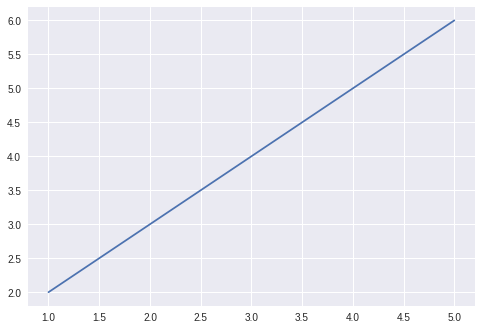

In [11]:
a = [1, 2, 3, 4, 5]
b = [2, 3, 4, 5, 6]

plt.plot(a, b)
plt.savefig('okok.png')

In [12]:
ls

Accuracy_BATCH_SIZE128EPOCHS10STEPS390BASELINEFalseTYPEtrain.png
Accuracy_BATCH_SIZE128EPOCHS1STEPS4BASELINEFalseTYPEtest.png
Accuracy_BATCH_SIZE128EPOCHS1STEPS4BASELINEFalseTYPEtrain.png
datalab/
lala.png
Loss_BATCH_SIZE128EPOCHS1STEPS4BASELINEFalseTYPEtest.png
Loss_BATCH_SIZE128EPOCHS1STEPS4BASELINEFalseTYPEtrain.png
okok.png


In [0]:
files.download('okok.png')